In [20]:
# Copyright (c) 2012-2018 by the GalSim developers team on GitHub
# https://github.com/GalSim-developers
#
# This file is part of GalSim: The modular galaxy image simulation toolkit.
# https://github.com/GalSim-developers/GalSim
#
# GalSim is free software: redistribution and use in source and binary forms,
# with or without modification, are permitted provided that the following
# conditions are met:
#
# 1. Redistributions of source code must retain the above copyright notice, this
#    list of conditions, and the disclaimer given in the accompanying LICENSE
#    file.
# 2. Redistributions in binary form must reproduce the above copyright notice,
#    this list of conditions, and the disclaimer given in the documentation
#    and/or other materials provided with the distribution.
#
"""
Demo #2
The second script in our tutorial about using GalSim in python scripts: examples/demo*.py.
(This file is designed to be viewed in a window 100 characters wide.)
This script is a bit more sophisticated, but still pretty basic.  We're still only making
a single image, but now the galaxy has an exponential radial profile and is sheared.
The PSF is a circular Moffat profile.  The noise is drawn from a Poisson distribution
using the flux from both the object and a background sky level to determine the
variance in each pixel.
New features introduced in this demo:
- obj = galsim.Exponential(flux, scale_radius)
- obj = galsim.Moffat(beta, flux, half_light_radius)
- obj = obj.shear(g1, g2)  -- with explanation of other ways to specify shear
- rng = galsim.BaseDeviate(seed)
- noise = galsim.PoissonNoise(rng, sky_level)
- galsim.hsm.EstimateShear(image, image_epsf)
"""

import sys
import os
import math
import logging
import galsim

########
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style
# plt.style.use(astropy_mpl_style)
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits
#######

def main(argv):
    """
    A little bit more sophisticated, but still pretty basic:
      - Use a sheared, exponential profile for the galaxy.
      - Convolve it by a circular Moffat PSF.
      - Add Poisson noise to the image.
    """
    # In non-script code, use getLogger(__name__) at module scope instead.
    logging.basicConfig(format="%(message)s", level=logging.INFO, stream=sys.stdout)
    logger = logging.getLogger("demo2")

    gal_flux = 1.e5    # counts
    gal_r0 = 2.7       # arcsec
    g1 = 0.1           #
    g2 = 0.2           #
    psf_beta = 5       #
    psf_re = 1.0       # arcsec
    pixel_scale = 0.2  # arcsec / pixel
    sky_level = 2.5e3  # counts / arcsec^2

    # This time use a particular seed, so the image is deterministic.
    # This is the same seed that is used in demo2.yaml, which means the images produced
    # by the two methods will be precisely identical.
    random_seed = 1534225


    logger.info('Starting demo script 2 using:')
    logger.info('    - sheared (%.2f,%.2f) exponential galaxy (flux = %.1e, scale radius = %.2f),',
                g1, g2, gal_flux, gal_r0)
    logger.info('    - circular Moffat PSF (beta = %.1f, re = %.2f),', psf_beta, psf_re)
    logger.info('    - pixel scale = %.2f,', pixel_scale)
    logger.info('    - Poisson noise (sky level = %.1e).', sky_level)

    # Initialize the (pseudo-)random number generator that we will be using below.
    # For a technical reason that will be explained later (demo9.py), we add 1 to the
    # given random seed here.
    rng = galsim.BaseDeviate(random_seed+1)

    # Define the galaxy profile.
    galexp = galsim.Exponential(flux=gal_flux, scale_radius=gal_r0)
    
    ####################
    original_GalImage = galexp.drawImage(scale=pixel_scale)
    file_name_original_GalImage = os.path.join('output','demo2_original_GalImage.fits')
    original_GalImage.write(file_name_original_GalImage)
    ####################

    # Shear the galaxy by some value.
    # There are quite a few ways you can use to specify a shape.
    # q, beta      Axis ratio and position angle: q = b/a, 0 < q < 1
    # e, beta      Ellipticity and position angle: |e| = (1-q^2)/(1+q^2)
    # g, beta      ("Reduced") Shear and position angle: |g| = (1-q)/(1+q)
    # eta, beta    Conformal shear and position angle: eta = ln(1/q)
    # e1,e2        Ellipticity components: e1 = e cos(2 beta), e2 = e sin(2 beta)
    # g1,g2        ("Reduced") shear components: g1 = g cos(2 beta), g2 = g sin(2 beta)
    # eta1,eta2    Conformal shear components: eta1 = eta cos(2 beta), eta2 = eta sin(2 beta)
    gal = galexp.shear(g1=g1, g2=g2)
    
    ##################
    sheared_GalImage = gal.drawImage(scale=pixel_scale)
    file_name_sheared_GalImage = os.path.join('output','demo2_sheared_GalImage.fits')
    sheared_GalImage.write(file_name_sheared_GalImage)
    ##################
    
    
    logger.debug('Made galaxy profile')

    # Define the PSF profile.
    psf = galsim.Moffat(beta=psf_beta, flux=1., half_light_radius=psf_re)
    
    ##################
    sheared_GalImage = gal.drawImage(scale=pixel_scale)
    file_name_sheared_GalImage = os.path.join('output','demo2_sheared_GalImage.fits')
    sheared_GalImage.write(file_name_sheared_GalImage)
    ##################
    
    logger.debug('Made PSF profile')

    # Final profile is the convolution of these.
    final = galsim.Convolve([gal, psf])
    final_noNoise = final.drawImage(scale=pixel_scale)
    
    file_name_final_noNoise = os.path.join('output','demo2_final_noNoise.fits')
    final_noNoise.write(file_name_final_noNoise)
    logger.debug('Convolved components into final profile')

    # Draw the image with a particular pixel scale.
    image = final.drawImage(scale=pixel_scale)
    # The "effective PSF" is the PSF as drawn on an image, which includes the convolution
    # by the pixel response.  We label it epsf here.
    image_epsf = psf.drawImage(scale=pixel_scale)
    logger.debug('Made image of the profile')

    # To get Poisson noise on the image, we will use a class called PoissonNoise.
    # However, we want the noise to correspond to what you would get with a significant
    # flux from tke sky.  This is done by telling PoissonNoise to add noise from a
    # sky level in addition to the counts currently in the image.
    #
    # One wrinkle here is that the PoissonNoise class needs the sky level in each pixel,
    # while we have a sky_level in counts per arcsec^2.  So we need to convert:
    sky_level_pixel = sky_level * pixel_scale**2
    noise = galsim.PoissonNoise(rng, sky_level=sky_level_pixel)
    image.addNoise(noise)
    logger.debug('Added Poisson noise')

    # Write the image to a file.
    if not os.path.isdir('output'):
        os.mkdir('output')
    file_name = os.path.join('output', 'demo2.fits')
    file_name_epsf = os.path.join('output','demo2_epsf.fits')
    image.write(file_name)
    image_epsf.write(file_name_epsf)
    logger.info('Wrote image to %r',file_name)
    logger.info('Wrote effective PSF image to %r',file_name_epsf)

    results = galsim.hsm.EstimateShear(image, image_epsf)

    logger.info('HSM reports that the image has observed shape and size:')
    logger.info('    e1 = %.3f, e2 = %.3f, sigma = %.3f (pixels)', results.observed_shape.e1,
                results.observed_shape.e2, results.moments_sigma)
    logger.info('When carrying out Regaussianization PSF correction, HSM reports distortions')
    logger.info('    e1, e2 = %.3f, %.3f',
                results.corrected_e1, results.corrected_e2)
    logger.info('Expected values in the limit that noise and non-Gaussianity are negligible:')
    exp_shear = galsim.Shear(g1=g1, g2=g2)
    logger.info('    g1, g2 = %.3f, %.3f', exp_shear.e1,exp_shear.e2)

if __name__ == "__main__":
    main(sys.argv)

Starting demo script 2 using:
    - sheared (0.10,0.20) exponential galaxy (flux = 1.0e+05, scale radius = 2.70),
    - circular Moffat PSF (beta = 5.0, re = 1.00),
    - pixel scale = 0.20,
    - Poisson noise (sky level = 2.5e+03).
Wrote image to 'output/demo2.fits'
Wrote effective PSF image to 'output/demo2_epsf.fits'
HSM reports that the image has observed shape and size:
    e1 = 0.172, e2 = 0.357, sigma = 16.769 (pixels)
When carrying out Regaussianization PSF correction, HSM reports distortions
    e1, e2 = 0.188, 0.390
Expected values in the limit that noise and non-Gaussianity are negligible:
    g1, g2 = 0.190, 0.381


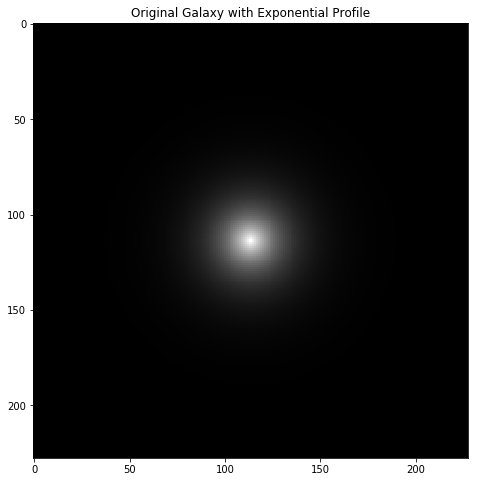

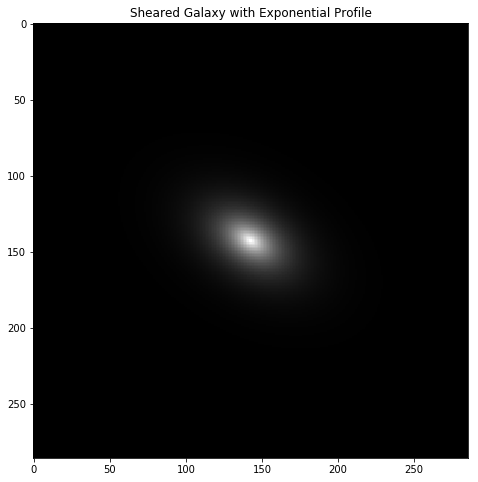

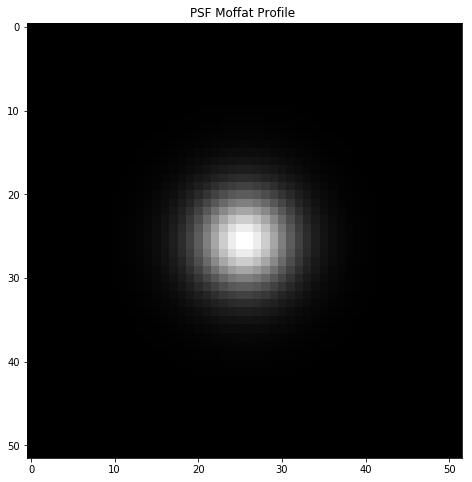

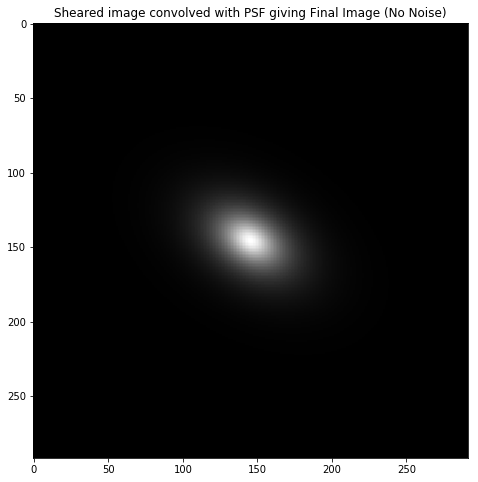

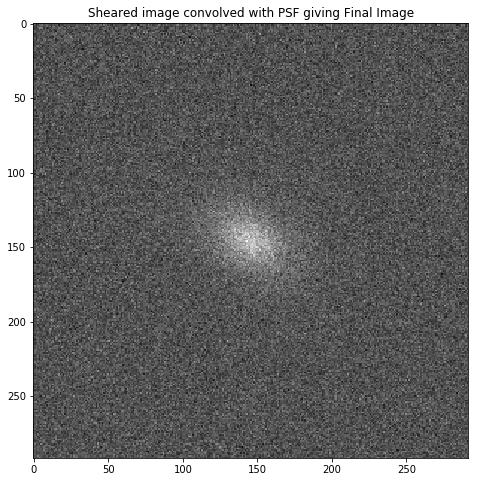

In [23]:
original_GalImage_file = get_pkg_data_filename('output/demo2_original_GalImage.fits')
original_GalImage_data = fits.getdata(original_GalImage_file, ext=0)
w = 8 
h = 8
plt.figure(figsize=(w,h))
plt.title('Original Galaxy with Exponential Profile')
plt.imshow(original_GalImage_data, cmap='gray')

sheared_GalImage_file = get_pkg_data_filename('output/demo2_sheared_GalImage.fits')
sheared_GalImage_data = fits.getdata(sheared_GalImage_file, ext=0)
plt.figure(figsize=(w,h))
plt.title('Sheared Galaxy with Exponential Profile')
plt.imshow(sheared_GalImage_data, cmap='gray')


PSF_Image_file = get_pkg_data_filename('output/demo2_epsf.fits')
PSF_Image_data = fits.getdata(PSF_Image_file, ext=0)
plt.figure(figsize=(w,h))
plt.title('PSF Moffat Profile ')
plt.imshow(PSF_Image_data, cmap='gray')

final_noNoise_file = get_pkg_data_filename('output/demo2_final_noNoise.fits')
final_noNoise_data = fits.getdata(final_noNoise_file, ext=0)
plt.figure(figsize=(w,h))
plt.title('Sheared image convolved with PSF giving Final Image (No Noise)')
plt.imshow(final_noNoise_data, cmap='gray')

final_Image_file = get_pkg_data_filename('output/demo2.fits')
final_Image_data = fits.getdata(final_Image_file, ext=0)
plt.figure(figsize=(w,h))
plt.title('Sheared image convolved with PSF giving Final Image')
plt.imshow(final_Image_data, cmap='gray')